# This is the python script to Goal D) of the thesis
It reloads the exported csv files with lineaments from Goal B) and performs various ways to analyse and interpret the data with unsupervised machine learning algorithms (e.g. k-means etc.)
https://scikit-learn.org/stable/modules/clustering.html

In [49]:
#from google.colab import drive
#drive.mount('/content/drive')

# Load the necessary libraries

In [50]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import entropy
import seaborn as sns
import math

from PIL import Image
import urllib.request


from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



from imageio import imread
from time import time as timer
import os
import tarfile

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML



In [51]:
# load all csv tables as individual data frames
# coordinates indicate 2m increments (e.g., 2 = 4m) and refer to the Swiss Coordinate system CH1903+ in the range
# --> the CV titles refer to Original dataset, and the numbers refer to 55, 99, 1515 Kernel for Gaussian Blur filter (see also python script Part 1)

df_list=[]
path="https://raw.githubusercontent.com/stfabbri/CAS_ADS_Thesis_final/main/CSV-OUTPUT/"
#path = "/content/drive/MyDrive/CSV_tables/"
name = "_image.csv"
index=['RefGeol1','Matlab_Ortho_slim','61','113']
for df_ in index:
    df_i = pd.read_csv("{}{}{}".format(path,df_,name),delimiter=';')
    df_list.append(df_i)
    
# Digital elevation model (dem)
#url    = '/content/drive/MyDrive/CSV_tables/DEM_10_clip_resampled.csv' #read dem
url_dem    = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/DEM_10_clip_resampled.zip?raw=true'
dem = pd.read_csv(url_dem,compression='zip',header=None, delimiter=';', dtype= 'float64')
df_dem = pd.DataFrame(dem)
cmap   = 'gist_earth'


In [52]:
# get lengths of individual data frames
length_list=[]
for df in df_list:
    len_i = len(df)
    length_list.append(len_i)

# get positions for splitting 
split_pos   = np.zeros(5)  
split_pos[1::] = np.cumsum(length_list)
split_pos = split_pos.astype(int)


# put all frames together
df_tot = pd.concat(df_list, axis=0)

In [53]:
# Calculate 2D properties (pixel domain)
# 2D mid point coordinates
df_tot['x mid'] = (df_tot['x1'] + df_tot['x2'])/2
df_tot['y mid'] = (df_tot['y1'] + df_tot['y2'])/2

# 2D euclidean distance
df_tot['2D segment length'] = round(np.sqrt((df_tot['x2']-df_tot['x1'])**2 +
                                            (df_tot['y2']-df_tot['y1'])**2),2)

# scale 2D properties to physical dimensions (i.e. in m) for length calculations

# cell size [m] 20 m perimeter divided by 2400 pixels = Cell size
scale_fac = 20/2400

df_tot['x start phys'] = scale_fac*df_tot['x1']
df_tot['y start phys'] = np.absolute(scale_fac*df_tot['y1'])
df_tot['x end phys']   = scale_fac*df_tot['x2']
df_tot['y end phys']   = np.absolute(scale_fac*df_tot['y2'])

# 2D mid point coordinates
df_tot['x mid phys'] = (df_tot['x start phys'] + df_tot['x end phys'])/2
df_tot['y mid phys'] = (df_tot['y start phys'] + df_tot['y end phys'])/2

# 2D euclidean distance
df_tot['2D segment length phys'] = round(np.sqrt((df_tot['x end phys']-df_tot['x start phys'])**2 +
                                            (df_tot['y end phys']-df_tot['y start phys'])**2),2)

# Fault strike orientation
df_tot['fault strike']   = abs(round(np.rad2deg(np.arctan((df_tot['y2']-df_tot['y1'])/
                                                      (df_tot['x2']-df_tot['x1'])))+90,2)-180)

df_tot.head(10)

x1      y1      x2      y2   x mid   y mid  2D segment length  \
0  2080.0  2355.0  2076.0  2399.0  2078.0  2377.0              44.18   
1   719.0  2391.0   741.0  2399.0   730.0  2395.0              23.41   
2   390.0  2392.0   418.0  2399.0   404.0  2395.5              28.86   
3   606.0  2371.0   624.0  2397.0   615.0  2384.0              31.62   
4   432.0  2387.0   435.0  2397.0   433.5  2392.0              10.44   
5  1382.0  2382.0  1388.0  2393.0  1385.0  2387.5              12.53   
6  1229.0  2392.0  1242.0  2393.0  1235.5  2392.5              13.04   
7  1072.0  2381.0  1077.0  2393.0  1074.5  2387.0              13.00   
8  1242.0  2393.0  1248.0  2392.0  1245.0  2392.5               6.08   
9  1216.0  2392.0  1229.0  2392.0  1222.5  2392.0              13.00   

   x start phys  y start phys  x end phys  y end phys  x mid phys  y mid phys  \
0     17.333333     19.625000   17.300000   19.991667   17.316667   19.808333   
1      5.991667     19.925000    6.175000   19.991667    6.083333   19.958333   
2      3.250000     19.933333    3.483333   19.991667    3.366667   19.962500   
3      5.050000     19.758333    5.200000   19.975000    5.125000   19.866667   
4      3.600000     19.891667    3.625000   19.975000    3.612500   19.933333   
5     11.516667     19.850000   11.566667   19.941667   11.541667   19.895833   
6     10.241667     19.933333   10.350000   19.941667   10.295833   19.937500   
7      8.933333     19.841667    8.975000   19.941667    8.954167   19.891667   
8     10.350000     19.941667   10.400000   19.933333   10.375000   19.937500   
9     10.133333     19.933333   10.241667   19.933333   10.187500   19.933333   

   2D segment length phys  fault strike  
0                    0.37        174.81  
1                    0.20         70.02  
2                    0.24         75.96  
3                    0.26         34.70  
4                    0.09         16.70  
5                    0.10         28.61  
6                    0.11         85.60  
7                    0.11         22.62  
8                    0.05         99.46  
9                    0.11         90.00

In [54]:
# Calculate 3D properties

# x and y needed switching for the lookup, due to the difference in geograph. and math. coordinates?
df_tot['z start phys'] = df_dem.lookup(df_tot['y1'].astype('int'),df_tot['x1'].astype('int'))
df_tot['z end phys']   = df_dem.lookup(df_tot['y2'].astype('int'),df_tot['x2'].astype('int'))
df_tot['z mid phys']   = df_dem.lookup(round(df_tot['y mid'].astype('int')-.5,0),round(df_tot['x mid'].astype('int')-.5,0))

# 3D euclidean distance
df_tot['3D segment length phys'] = round(np.sqrt((df_tot['x end phys']-df_tot['x start phys'])**2 +
                                            (df_tot['y end phys']-df_tot['y start phys'])**2 +
                                            (df_tot['z end phys']-df_tot['z start phys'])**2),2)

# Get max and min values
column = df_tot["z mid phys"]
max_z  = 100*math.ceil(column.max()/100)
min_z  = 100*math.floor(column.min()/100)

df_tot.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  


x1      y1      x2      y2   x mid   y mid  2D segment length  \
0  2080.0  2355.0  2076.0  2399.0  2078.0  2377.0              44.18   
1   719.0  2391.0   741.0  2399.0   730.0  2395.0              23.41   
2   390.0  2392.0   418.0  2399.0   404.0  2395.5              28.86   
3   606.0  2371.0   624.0  2397.0   615.0  2384.0              31.62   
4   432.0  2387.0   435.0  2397.0   433.5  2392.0              10.44   
5  1382.0  2382.0  1388.0  2393.0  1385.0  2387.5              12.53   
6  1229.0  2392.0  1242.0  2393.0  1235.5  2392.5              13.04   
7  1072.0  2381.0  1077.0  2393.0  1074.5  2387.0              13.00   
8  1242.0  2393.0  1248.0  2392.0  1245.0  2392.5               6.08   
9  1216.0  2392.0  1229.0  2392.0  1222.5  2392.0              13.00   

   x start phys  y start phys  x end phys  y end phys  x mid phys  y mid phys  \
0     17.333333     19.625000   17.300000   19.991667   17.316667   19.808333   
1      5.991667     19.925000    6.175000   19.991667    6.083333   19.958333   
2      3.250000     19.933333    3.483333   19.991667    3.366667   19.962500   
3      5.050000     19.758333    5.200000   19.975000    5.125000   19.866667   
4      3.600000     19.891667    3.625000   19.975000    3.612500   19.933333   
5     11.516667     19.850000   11.566667   19.941667   11.541667   19.895833   
6     10.241667     19.933333   10.350000   19.941667   10.295833   19.937500   
7      8.933333     19.841667    8.975000   19.941667    8.954167   19.891667   
8     10.350000     19.941667   10.400000   19.933333   10.375000   19.937500   
9     10.133333     19.933333   10.241667   19.933333   10.187500   19.933333   

   2D segment length phys  fault strike  z start phys  z end phys  z mid phys  \
0                    0.37        174.81      1920.111    1920.109    1920.116   
1                    0.20         70.02      1920.668    1920.726    1920.698   
2                    0.24         75.96      1920.659    1920.771    1920.722   
3                    0.26         34.70      1920.603    1920.650    1920.628   
4                    0.09         16.70      1920.738    1920.775    1920.756   
5                    0.10         28.61      1920.912    1920.885    1920.900   
6                    0.11         85.60      1921.339    1921.334    1921.337   
7                    0.11         22.62      1921.070    1921.139    1921.087   
8                    0.05         99.46      1921.334    1921.327    1921.331   
9                    0.11         90.00      1921.334    1921.339    1921.340   

   3D segment length phys  
0                    0.37  
1                    0.20  
2                    0.27  
3                    0.27  
4                    0.09  
5                    0.11  
6                    0.11  
7                    0.13  
8                    0.05  
9                    0.11

In [55]:
df_index=['RefGeol1','Matlab_Ortho_slim','61','113']
df_list2=[]
len_list=[]
for i in range(0,len(df_index),1):
        df_i= df_tot.iloc[split_pos[i]:split_pos[(i+1)],:]
        df_list2.append(df_i)
        df_i.to_csv(df_index[i],index=False)
              
for i in range(0,len(df_index),1):
        len_i = len(df_list2[i])
        len_list.append(len_i)

In [56]:
# Data cleaning
for i in range(1,4):
  df_tot_ind1 = df_list2[i][ (df_list2[i]['2D segment length'] >= 180) ].index # remove lineaments larger 180 pixels
  df_list2[i].drop(df_tot_ind1, inplace=True)
  df_tot_ind2 = df_list2[i][ (df_list2[i]['fault strike'] == 90) & (df_list2[i]['2D segment length'] >= 80) ].index
  df_list2[i].drop(df_tot_ind2, inplace=True)
  df_tot_ind3 = df_list2[i][ (df_list2[i]['fault strike'] == 180) & (df_list2[i]['2D segment length'] >= 80) ].index
  df_list2[i].drop(df_tot_ind3, inplace=True)
  df_tot_ind4 = df_list2[i][ (df_list2[i]['fault strike'] == 0) & (df_list2[i]['2D segment length'] >= 80) ].index
  df_list2[i].drop(df_tot_ind4, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
print(len(df_list2[1]))
print(len(df_list2[2]))
print(len(df_list2[3]))

2454
992
1702


# Plot data in various ways to inquire clustering potential

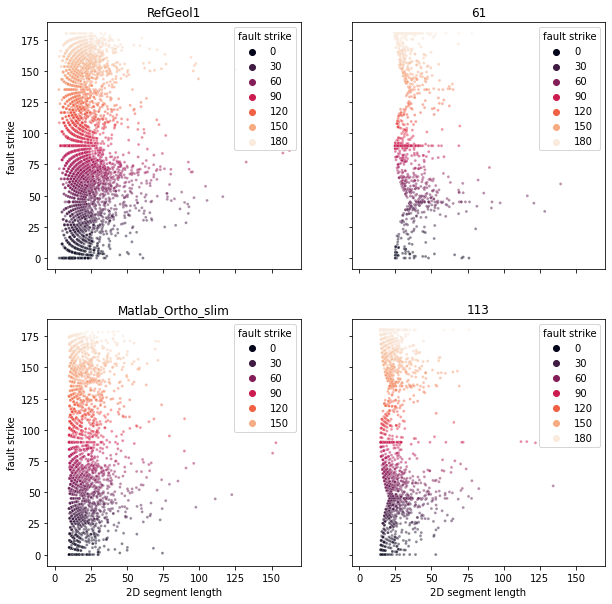

In [58]:
#FIGURES AFTER cleaning (2D segment length)
cmap ="rocket"

f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0   # i=0 for GeolRef, 1 for Matlab results, 2 for 61, 3 for 113
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = '2D segment length',y = 'fault strike',s=8)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150)
        else:
            sns.scatterplot(data = df_list2[i], x = '2D segment length', y= 'fault strike', hue = 'fault strike', s=8,
                            legend=True, palette=cmap, ax=axes[k,j],
                            sizes=(10,500), alpha=0.5)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1



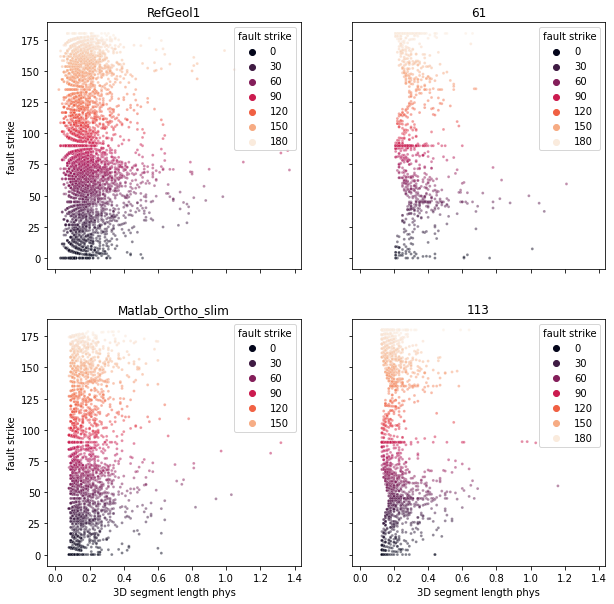

In [59]:
#FIGURES AFTER cleaning (3D segment length)
cmap ="rocket"

f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150)
        else:
            sns.scatterplot(data = df_list2[i], x = '3D segment length phys', y= 'fault strike', hue = 'fault strike', s=8,
                            legend=True, palette=cmap, ax=axes[k,j],
                            sizes=(10,500), alpha=0.5)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1


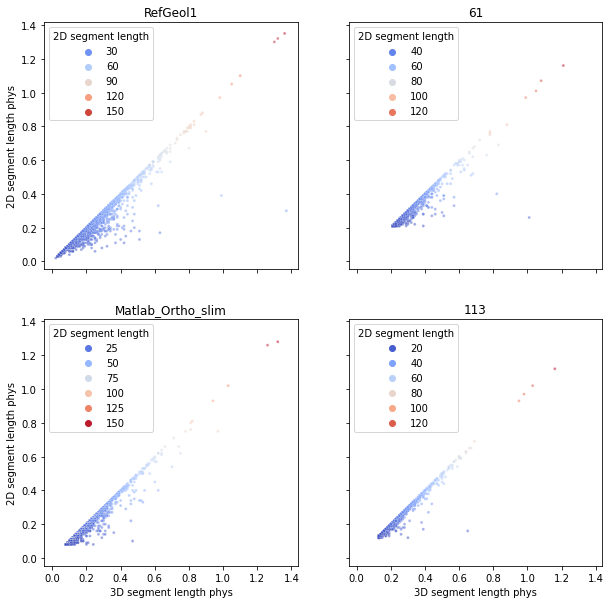

In [60]:
#FIGURES AFTER cleaning
cmap ="coolwarm"

f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = '2D segment length phys',s=8)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150)
        else:
            sns.scatterplot(data = df_list2[i], x = '3D segment length phys', y= '2D segment length phys', hue = '2D segment length', s=8,
                            legend=True, palette=cmap, ax=axes[k,j],
                            sizes=(10,500), alpha=0.5)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1


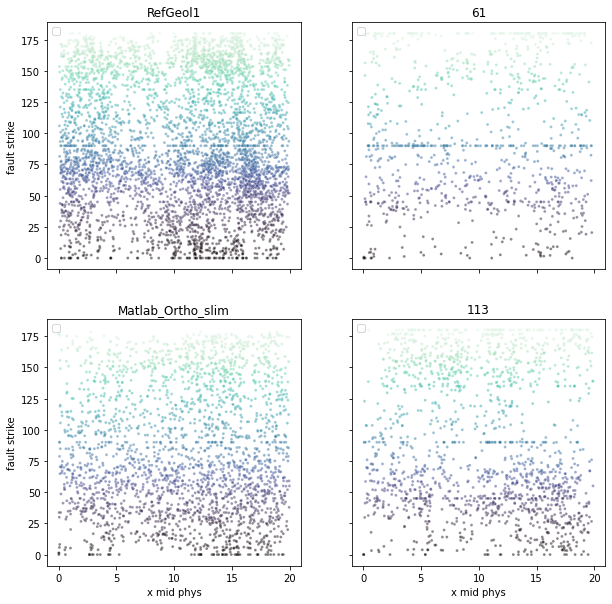

In [61]:
#FIGURES AFTER cleaning
cmap ="mako"

f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = 'x mid phys',y = 'fault strike',s=8)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          #axes[k,j].legend(loc="right")
          #axes[k,j].set_ylim=(1,150)
        else:
            sns.scatterplot(data = df_list2[i], x = 'x mid phys', y= 'fault strike', hue = 'fault strike', s=8,
                            legend=False, palette=cmap, ax=axes[k,j],
                            sizes=(1,100), alpha=0.5)
            axes[k,j].legend(loc=2)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1

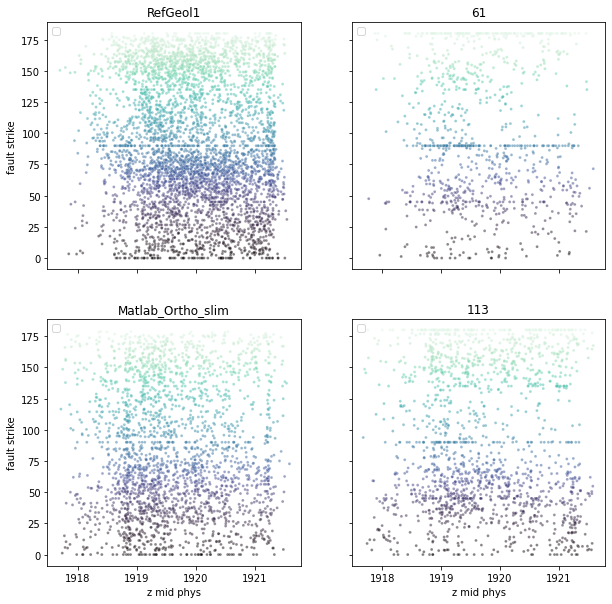

In [62]:
#FIGURES AFTER cleaning
cmap ="mako"

f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = 'z mid phys',y = 'fault strike',s=8)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150)
        else:
            sns.scatterplot(data = df_list2[i], x = 'z mid phys', y= 'fault strike', hue = 'fault strike', s=8,
                            legend=False, palette=cmap, ax=axes[k,j],
                            sizes=(10,500), alpha=0.5)
            axes[k,j].legend(loc=2)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1

# Preparation for CLustering
list content needs to be assigned to arrays. Arrays of x and y axis need to be merged and transposed for clustering input (shape: (XX , 2)

In [63]:
### IF time -> optimze code with for loop
# z mid phys = zmp
my_array_ref_zmp =np.array(df_list2[0]['z mid phys'])
my_array_mat_zmp =np.array(df_list2[1]['z mid phys'])
my_array_61_zmp  =np.array(df_list2[2]['z mid phys'])
my_array_113_zmp =np.array(df_list2[3]['z mid phys'])

# x mid phys = xmp
my_array_ref_xmp =np.array(df_list2[0]['x mid phys'])
my_array_mat_xmp =np.array(df_list2[1]['x mid phys'])
my_array_61_xmp  =np.array(df_list2[2]['x mid phys'])
my_array_113_xmp =np.array(df_list2[3]['x mid phys'])

# Fault Strike = fs
my_array_ref_fs =np.array(df_list2[0]['fault strike'])
my_array_mat_fs =np.array(df_list2[1]['fault strike'])
my_array_61_fs  =np.array(df_list2[2]['fault strike'])
my_array_113_fs =np.array(df_list2[3]['fault strike'])

# 2D segment length phys = 2Dslp
my_array_ref_2Dslp =np.array(df_list2[0]['2D segment length phys'])
my_array_mat_2Dslp =np.array(df_list2[1]['2D segment length phys'])
my_array_61_2Dslp  =np.array(df_list2[2]['2D segment length phys'])
my_array_113_2Dslp =np.array(df_list2[3]['2D segment length phys'])

# 3D segment length phys = 3Dslp
my_array_ref_3Dslp =np.array(df_list2[0]['3D segment length phys'])
my_array_mat_3Dslp =np.array(df_list2[1]['3D segment length phys'])
my_array_61_3Dslp  =np.array(df_list2[2]['3D segment length phys'])
my_array_113_3Dslp =np.array(df_list2[3]['3D segment length phys'])


# zmp vs fs
my_array_ref_zmp_fs   = np.asarray([my_array_ref_zmp, my_array_ref_fs])
t_my_array_ref_zmp_fs = np.transpose(my_array_ref_zmp_fs)

my_array_mat_zmp_fs   = np.asarray([my_array_mat_zmp, my_array_mat_fs])
t_my_array_mat_zmp_fs = np.transpose(my_array_mat_zmp_fs)

my_array_61_zmp_fs   = np.asarray([my_array_61_zmp, my_array_61_fs])
t_my_array_61_zmp_fs = np.transpose(my_array_61_zmp_fs)

my_array_113_zmp_fs   = np.asarray([my_array_113_zmp, my_array_113_fs])
t_my_array_113_zmp_fs = np.transpose(my_array_113_zmp_fs)

# 3Dslp vs fs
my_array_ref_3Dslp_fs   = np.asarray([my_array_ref_3Dslp, my_array_ref_fs])
t_my_array_ref_3Dslp_fs = np.transpose(my_array_ref_3Dslp_fs)

my_array_mat_3Dslp_fs   = np.asarray([my_array_mat_3Dslp, my_array_mat_fs])
t_my_array_mat_3Dslp_fs = np.transpose(my_array_mat_3Dslp_fs)

my_array_61_3Dslp_fs   = np.asarray([my_array_61_3Dslp, my_array_61_fs])
t_my_array_61_3Dslp_fs = np.transpose(my_array_61_3Dslp_fs)

my_array_113_3Dslp_fs   = np.asarray([my_array_113_3Dslp, my_array_113_fs])
t_my_array_113_3Dslp_fs = np.transpose(my_array_113_3Dslp_fs)


# 3Dslp vs 2Dslp
my_array_ref_3Dslp_2Dslp   = np.asarray([my_array_ref_3Dslp, my_array_ref_2Dslp])
t_my_array_ref_3Dslp_2Dslp = np.transpose(my_array_ref_3Dslp_2Dslp)

my_array_mat_3Dslp_2Dslp   = np.asarray([my_array_mat_3Dslp, my_array_mat_2Dslp])
t_my_array_mat_3Dslp_2Dslp = np.transpose(my_array_mat_3Dslp_2Dslp)

my_array_61_3Dslp_2Dslp   = np.asarray([my_array_61_3Dslp, my_array_61_2Dslp])
t_my_array_61_3Dslp_2Dslp = np.transpose(my_array_61_3Dslp_2Dslp)

my_array_113_3Dslp_2Dslp   = np.asarray([my_array_113_3Dslp, my_array_113_2Dslp])
t_my_array_113_3Dslp_2Dslp = np.transpose(my_array_113_3Dslp_2Dslp)

#t_my_array1 =np.transpose(my_array1)
#my_array_fs =np.array(df_list2[m]['fault strike'])
#t_my_array2 =np.transpose(my_array2)
#my_array_zmp_fs = np.asarray([my_array_zmp, my_array_fs])
#print(my_array_zmp_fs.shape)

In [64]:
print(t_my_array_61_3Dslp_2Dslp.shape)

(992, 2)


Collect arrays in list

In [65]:
df_zmp_fs = [t_my_array_ref_zmp_fs,t_my_array_mat_zmp_fs,t_my_array_61_zmp_fs,t_my_array_113_zmp_fs]
df_3Dslp_fs = [t_my_array_ref_3Dslp_fs,t_my_array_mat_3Dslp_fs,t_my_array_61_3Dslp_fs,t_my_array_113_3Dslp_fs]
df_3Dslp_2Dslp = [t_my_array_ref_3Dslp_2Dslp,t_my_array_mat_3Dslp_2Dslp,t_my_array_61_3Dslp_2Dslp,t_my_array_113_3Dslp_2Dslp]

# k-Means with XX clusters

Clustering z mid position vs fault strike

[Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, 'z mid phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, 'z mid phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, 'z mid phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, 'z mid phys')]

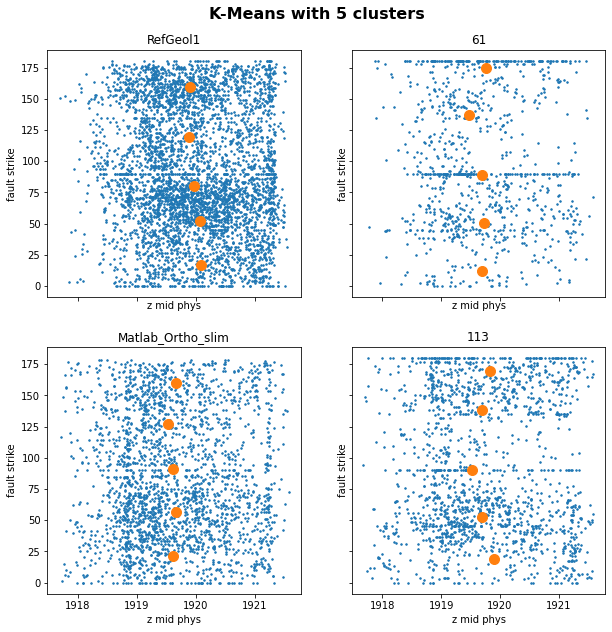

In [66]:
# k-Mean with XX clusters ZMP vs FS
f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''

n_clusters = 5

i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          #clusterer1 = KMeans(n_clusters=2, random_state=50)
          clusterer2.fit(df_zmp_fs[i])

          #g=sns.scatterplot(data=df_list2[i],x = 'z mid phys',y = 'fault strike',s=8)
          #sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8)
          axes[k,j].plot(df_list2[i]['z mid phys'],df_list2[i]['fault strike'],'o', markersize=1.5)
          axes[k,j].plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          #axes[k,j].set_title("{}{}".format(index[i],degree))
          #axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150)
        else:
            #clusterer2 = KMeans(n_clusters=2, random_state=50)
            clusterer2 = KMeans(n_clusters=n_clusters, random_state=50)
            clusterer2.fit(df_zmp_fs[i])
            #sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8, 
                            #legend=False, palette=cmap, ax=axes[k,j],
                            #sizes=(10,500), alpha=0.5)
            axes[k,j].plot(df_list2[i]['z mid phys'],df_list2[i]['fault strike'],'o', markersize=1.5)
            axes[k,j].plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)
            #axes[k,j].legend(loc=2)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1

# make title and subtitles
f_vis1.suptitle("K-Means with {} clusters".format(n_clusters), y=0.94, fontsize=16, fontweight='bold')
plt.setp(axes, xlabel='z mid phys', ylabel='fault strike')
#f_vis1.text(0.5, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
#f_vis1.text(0.05, 0.5, 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')

Clustering fault strike vs 3D segment length

[Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, '3D segment length phys')]

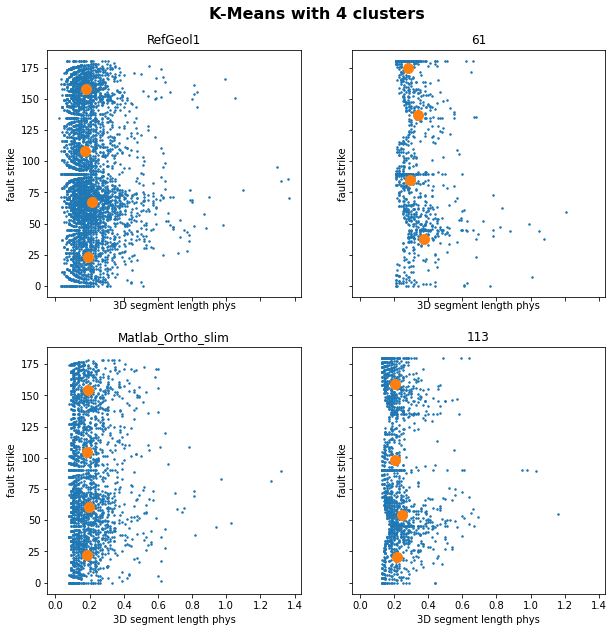

In [67]:
# k-Mean with XX clusters 3Dslp vs FS
f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')

#### CHANGE AMOUNT OF CLUSTERS HERE
n_clusters = 4

i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          #clusterer1 = KMeans(n_clusters=2, random_state=50)
          clusterer2.fit(df_3Dslp_fs[i])

          #g=sns.scatterplot(data=df_list2[i],x = 'z mid phys',y = 'fault strike',s=8)
          #sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8)
          axes[k,j].plot(df_list2[i]['3D segment length phys'],df_list2[i]['fault strike'],'o', markersize=1.5)
          axes[k,j].plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          #axes[k,j].set_title("{}{}".format(index[i],degree))
          #axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150)
        else:
            #clusterer2 = KMeans(n_clusters=2, random_state=50)
            clusterer2 = KMeans(n_clusters=n_clusters, random_state=50)
            clusterer2.fit(df_3Dslp_fs[i])
            #sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8, 
                            #legend=False, palette=cmap, ax=axes[k,j],
                            #sizes=(10,500), alpha=0.5)
            axes[k,j].plot(df_list2[i]['3D segment length phys'],df_list2[i]['fault strike'],'o', markersize=1.5)
            axes[k,j].plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)
            #axes[k,j].legend(loc=2)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1

# make title and subtitles
f_vis1.suptitle("K-Means with {} clusters".format(n_clusters), y=0.94, fontsize=16, fontweight='bold')
plt.setp(axes, xlabel='3D segment length phys', ylabel='fault strike')
#f_vis1.text(0.5, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
#f_vis1.text(0.05, 0.5, 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')

Clustering 3D segment length phys vs 2 segment length phys

[Text(0, 0.5, '2D segment length phys'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, '2D segment length phys'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, '2D segment length phys'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, '2D segment length phys'),
 Text(0.5, 0, '3D segment length phys')]

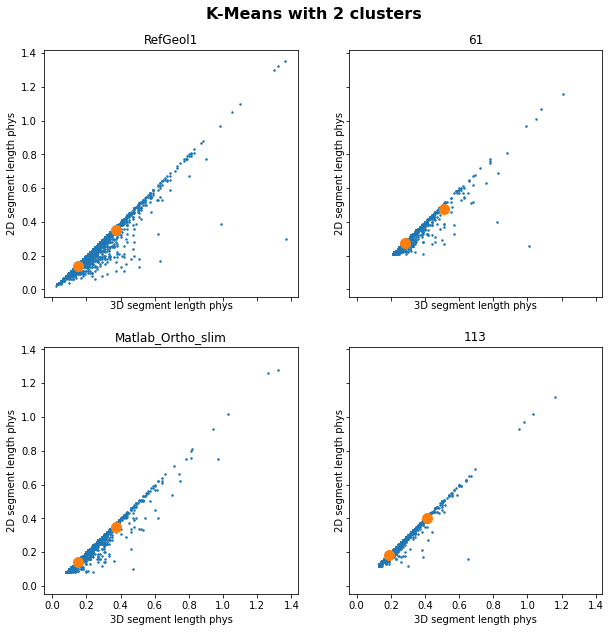

In [68]:
# k-Mean with XX clusters 3Dslp vs 2Dslp
f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')

#### CHANGE AMOUNT OF CLUSTERS HERE
n_clusters = 2

i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          #clusterer1 = KMeans(n_clusters=2, random_state=50)
          clusterer2.fit(df_3Dslp_2Dslp[i])

          #g=sns.scatterplot(data=df_list2[i],x = 'z mid phys',y = 'fault strike',s=8)
          #sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8)
          axes[k,j].plot(df_list2[i]['3D segment length phys'],df_list2[i]['2D segment length phys'],'o', markersize=1.5)
          axes[k,j].plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)

        else:
            #clusterer2 = KMeans(n_clusters=2, random_state=50)
            clusterer2 = KMeans(n_clusters=n_clusters, random_state=50)
            clusterer2.fit(df_3Dslp_2Dslp[i])
            #sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8, 
                            #legend=False, palette=cmap, ax=axes[k,j],
                            #sizes=(10,500), alpha=0.5)
            axes[k,j].plot(df_list2[i]['3D segment length phys'],df_list2[i]['2D segment length phys'],'o', markersize=1.5)
            axes[k,j].plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)
            #axes[k,j].legend(loc=2)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1

# make title and subtitles
f_vis1.suptitle("K-Means with {} clusters".format(n_clusters), y=0.94, fontsize=16, fontweight='bold')
plt.setp(axes, xlabel='3D segment length phys', ylabel='2D segment length phys')
#f_vis1.text(0.5, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
#f_vis1.text(0.05, 0.5, 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')

# DBSCAN Clustering

[Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, 'fault strike'),
 Text(0.5, 0, '3D segment length phys')]

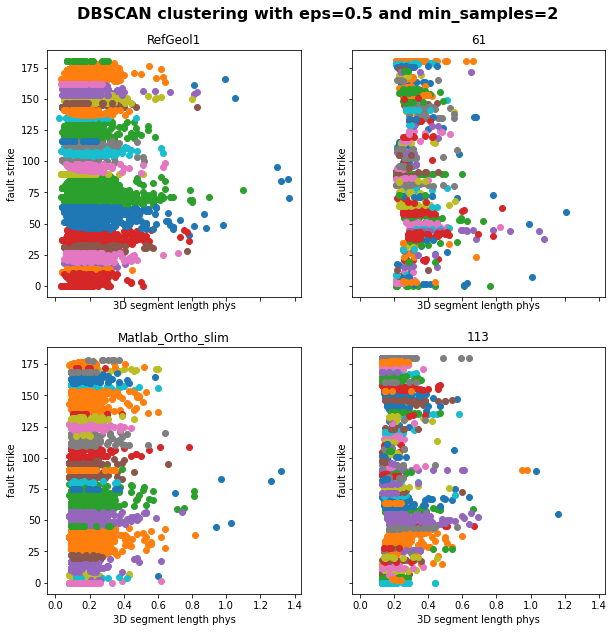

In [69]:
# # DBSCAN Clustering for 3Dslp vs fs
# affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN

f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''

#### CHANGE PARAMETERS HERE #######
eps=0.5
min_samples=2

i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          model = DBSCAN(eps=eps, min_samples=min_samples)
          yhat = model.fit_predict(df_3Dslp_fs[i])
          clusters = unique(yhat)
          for cluster in clusters:
            row_ix = where(yhat == cluster)
            axes[k,j].scatter(df_3Dslp_fs[i][row_ix, 0], df_3Dslp_fs[i][row_ix, 1])


        else:
          model2 = DBSCAN(eps=eps, min_samples=min_samples)
          yhat = model2.fit_predict(df_3Dslp_fs[i])
          clusters = unique(yhat)
          for cluster in clusters:
            row_ix = where(yhat == cluster)
            axes[k,j].scatter(df_3Dslp_fs[i][row_ix, 0], df_3Dslp_fs[i][row_ix, 1])
          axes[k,j].set_title("{}{}".format(index[i],degree))
            #clusterer2 = KMeans(n_clusters=2, random_state=50)
            #clusterer2 = KMeans(n_clusters=n_clusters, random_state=50)
            #clusterer2.fit(df_3Dslp_2Dslp[i])
            #sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8, 
                            #legend=False, palette=cmap, ax=axes[k,j],
                            #sizes=(10,500), alpha=0.5)
            #axes[k,j].plot(df_list2[i]['3D segment length phys'],df_list2[i]['2D segment length phys'],'o', markersize=1.5)
            #axes[k,j].plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)
            #axes[k,j].legend(loc=2)
            	#axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1

# make title and subtitles
f_vis1.suptitle("DBSCAN clustering with eps={} and min_samples={}".format(eps,min_samples), y=0.94, fontsize=16, fontweight='bold')
plt.setp(axes, xlabel='3D segment length phys', ylabel='fault strike')
#f_vis1.text(0.5, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
#f_vis1.text(0.05, 0.5, 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')

# Birch Clustering

[Text(0, 0.5, '2D segment length phys'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, '2D segment length phys'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, '2D segment length phys'),
 Text(0.5, 0, '3D segment length phys'),
 Text(0, 0.5, '2D segment length phys'),
 Text(0.5, 0, '3D segment length phys')]

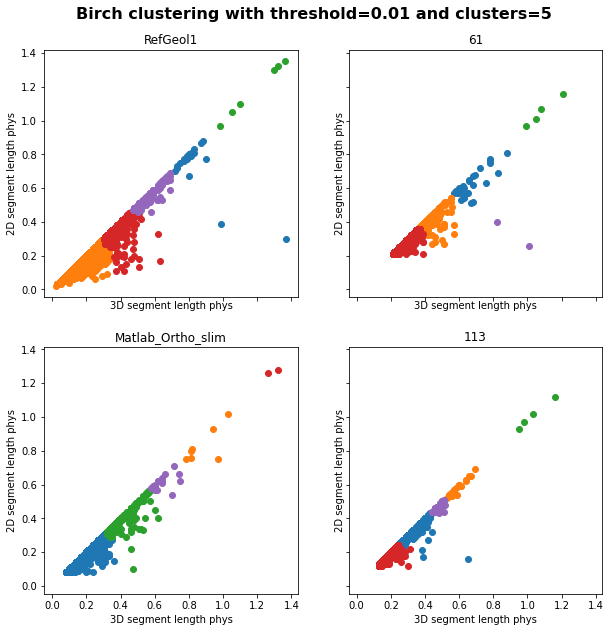

In [70]:
# # Birch Clustering for 3Dslp vs 2Dslp
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch

f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''

#### CHANGE PARAMETERS HERE
threshold = 0.01
n_clusters = 5

i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          model1 = Birch(threshold=threshold, n_clusters=n_clusters)
          model1.fit(df_3Dslp_2Dslp[[i]])
          yhat = model1.predict(df_3Dslp_2Dslp[i])
          clusters = unique(yhat)
          for cluster in clusters:
            row_ix = where(yhat == cluster)
            axes[k,j].scatter(df_3Dslp_2Dslp[i][row_ix, 0], df_3Dslp_2Dslp[i][row_ix, 1])


        else:
          model1 = Birch(threshold=threshold, n_clusters=n_clusters)
          model1.fit(df_3Dslp_2Dslp[i])
          yhat = model1.predict(df_3Dslp_2Dslp[i])
          clusters = unique(yhat)
          for cluster in clusters:
            row_ix = where(yhat == cluster)
            axes[k,j].scatter(df_3Dslp_2Dslp[i][row_ix, 0], df_3Dslp_2Dslp[i][row_ix, 1])
          axes[k,j].set_title("{}{}".format(index[i],degree))
            #clusterer2 = KMeans(n_clusters=2, random_state=50)
            #clusterer2 = KMeans(n_clusters=n_clusters, random_state=50)
            #clusterer2.fit(df_3Dslp_2Dslp[i])
            #sns.scatterplot(data=df_list2[i],x = '3D segment length phys',y = 'fault strike',s=8, 
                            #legend=False, palette=cmap, ax=axes[k,j],
                            #sizes=(10,500), alpha=0.5)
            #axes[k,j].plot(df_list2[i]['3D segment length phys'],df_list2[i]['2D segment length phys'],'o', markersize=1.5)
            #axes[k,j].plot(clusterer2.cluster_centers_[:,0],clusterer2.cluster_centers_[:,1],'o',markersize=10)
            #axes[k,j].legend(loc=2)
            	#axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1

# make title and subtitles
f_vis1.suptitle("Birch clustering with threshold={} and clusters={}".format(threshold,n_clusters), y=0.94, fontsize=16, fontweight='bold')
plt.setp(axes, xlabel='3D segment length phys', ylabel='2D segment length phys')
#f_vis1.text(0.5, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
#f_vis1.text(0.05, 0.5, 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')

# Affinity propagation clustering

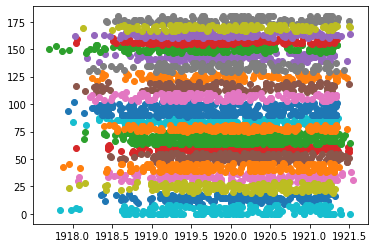

In [71]:
# Affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot
# define dataset

damping=0.9 # must be smaller than 1!
i=0
# define the model
model = AffinityPropagation(damping=damping)
# fit the model
model.fit(df_zmp_fs[i])
# assign a cluster to each example
yhat = model.predict(df_zmp_fs[i])
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(df_zmp_fs[i][row_ix, 0], df_zmp_fs[i][row_ix, 1])
# show the plot
pyplot.show()

# gaussian mixture clustering

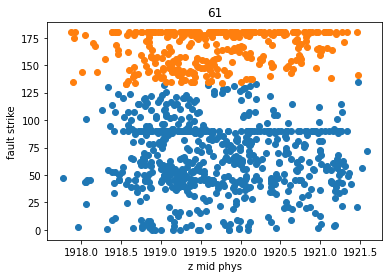

In [72]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define dataset

i=2
n_components=2

# define the model
model = GaussianMixture(n_components=n_components)
# fit the model
model.fit(df_zmp_fs[i])
# assign a cluster to each example
yhat = model.predict(df_zmp_fs[i])
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(df_zmp_fs[i][row_ix, 0],df_zmp_fs[i][row_ix, 1])


# show the plot
plt.title("{}{}".format(index[i],degree))
plt.xlabel('z mid phys')
plt.ylabel('fault strike')
pyplot.show()

# Mean Shift Clustering

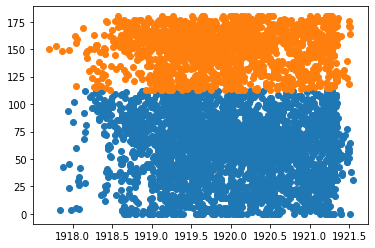

In [73]:
# mean shift clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot

i=0
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = MeanShift()
# fit model and predict clusters
yhat = model.fit_predict(df_zmp_fs[i])
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(df_zmp_fs[i][row_ix, 0], df_zmp_fs[i][row_ix, 1])
# show the plot
pyplot.show()

Text(0, 0.5, 'fault strike')

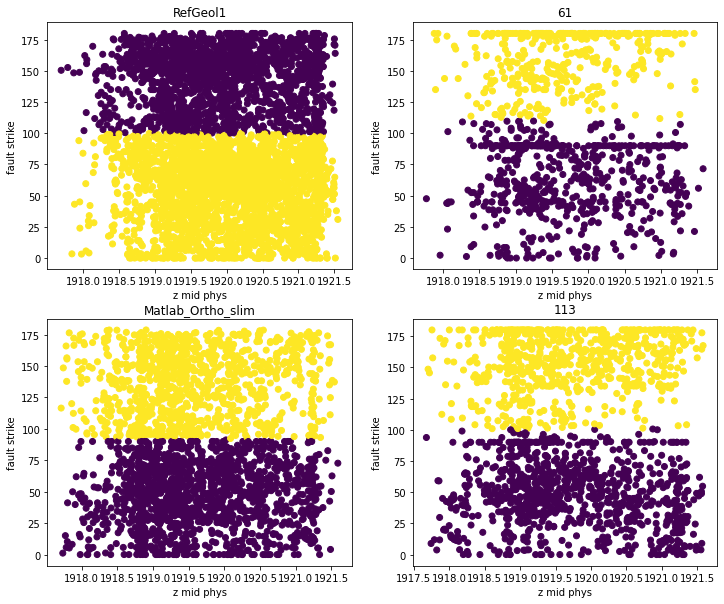

In [74]:
# K-Means with color-coded clusters
## If time, optimize with for loop
n_clusters=2

i=0
plt.figure(figsize=(12,10))
plt.subplot(221)
clusterer1 = KMeans(n_clusters=n_clusters, random_state=50)
clusterer1.fit(df_zmp_fs[i])
cluster_labels=clusterer1.predict(df_zmp_fs[i])
plt.scatter(df_zmp_fs[i][:,0],df_zmp_fs[i][:,1],c=cluster_labels)
plt.title("{}{}".format(index[i],degree))
plt.xlabel('z mid phys')
plt.ylabel('fault strike')

i=1
plt.subplot(223)
clusterer2 = KMeans(n_clusters=n_clusters, random_state=50)
clusterer2.fit(df_zmp_fs[i])
cluster_labels=clusterer2.predict(df_zmp_fs[i])

plt.scatter(df_zmp_fs[i][:,0],df_zmp_fs[i][:,1],c=cluster_labels)
plt.title("{}{}".format(index[i],degree))
plt.xlabel('z mid phys')
plt.ylabel('fault strike')


i=2
plt.subplot(222)
clusterer3 = KMeans(n_clusters=n_clusters, random_state=50)
clusterer3.fit(df_zmp_fs[i])
cluster_labels=clusterer3.predict(df_zmp_fs[i])

plt.scatter(df_zmp_fs[i][:,0],df_zmp_fs[i][:,1],c=cluster_labels)
plt.title("{}{}".format(index[i],degree))
plt.xlabel('z mid phys')
plt.ylabel('fault strike')

i=3
plt.subplot(224)
clusterer4 = KMeans(n_clusters=n_clusters, random_state=50)
clusterer4.fit(df_zmp_fs[i])
cluster_labels=clusterer4.predict(df_zmp_fs[i])

plt.scatter(df_zmp_fs[i][:,0],df_zmp_fs[i][:,1],c=cluster_labels)
plt.title("{}{}".format(index[i],degree))
plt.xlabel('z mid phys')
plt.ylabel('fault strike')


# Silhouette for clusterer 1: z mid phys vs fault strike

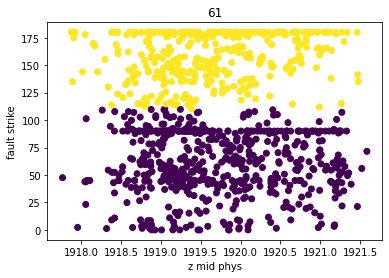

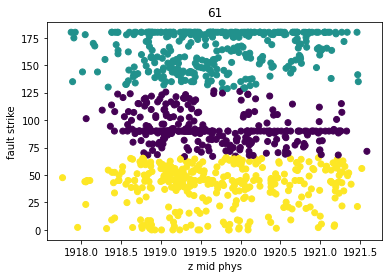

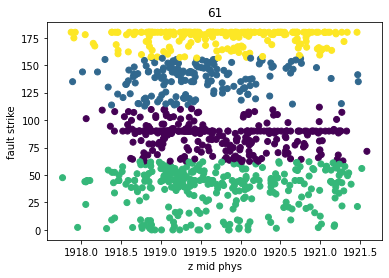

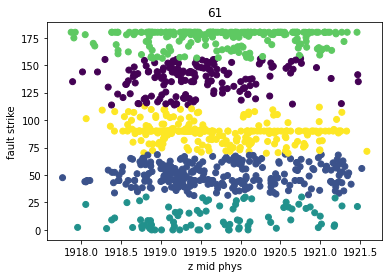

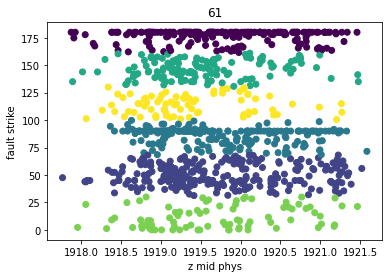

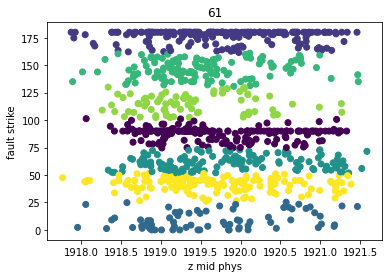

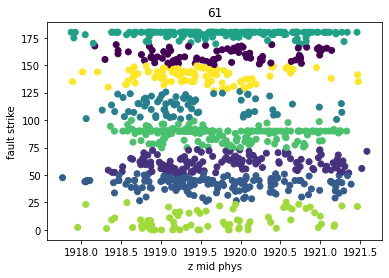

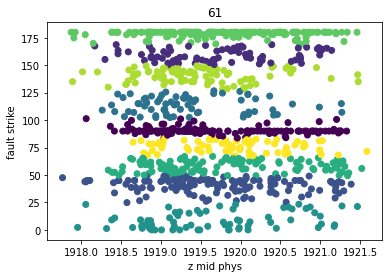

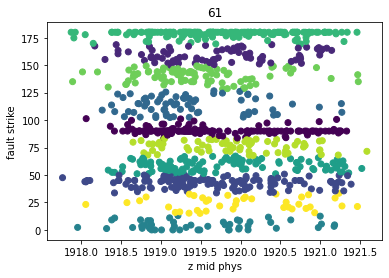

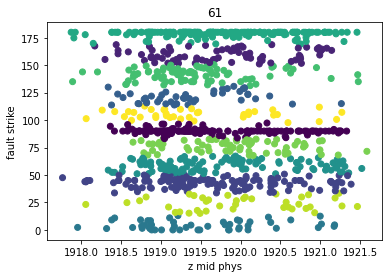

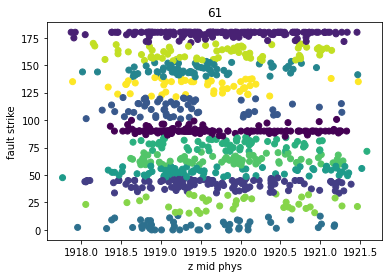

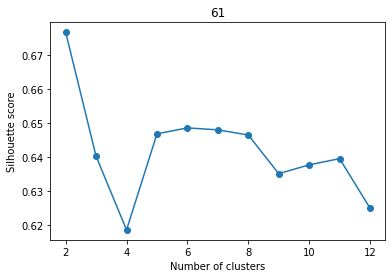

In [75]:
sil=[]
#plt.figure(figsize=(15,10))

i=2 # i=0 for GeolRef, 1 for Matlab results, 2 for 61, 3 for 113
for iclust in range(2,13):
            clusterer = KMeans(n_clusters=iclust, random_state=500)
            cluster_labels = clusterer.fit_predict(df_zmp_fs[i])
            score=silhouette_score(df_zmp_fs[i],cluster_labels)
            sil.append(score)
            plt.scatter(df_zmp_fs[i][:,0],df_zmp_fs[i][:,1],c=cluster_labels)
            plt.title("{}{}".format(index[i],degree))
            plt.xlabel('z mid phys')
            plt.ylabel('fault strike')
            plt.show()
    
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title("{}{}".format(index[i],degree))
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()




# Silhouette for clusterer 1: 3D segment length phys vs fault strike

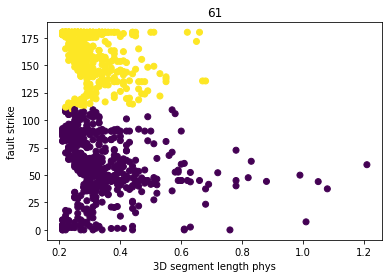

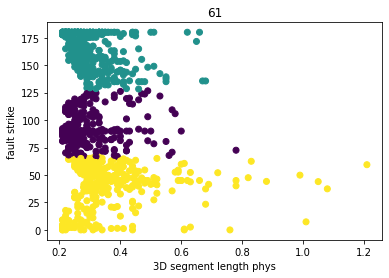

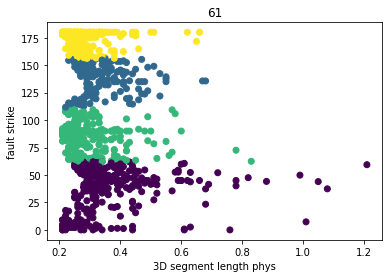

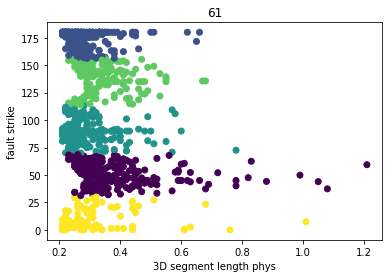

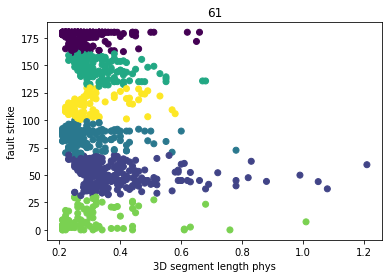

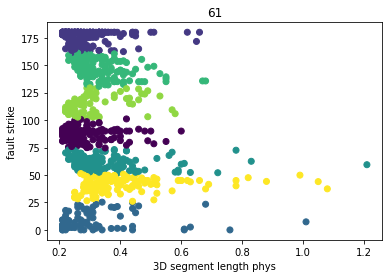

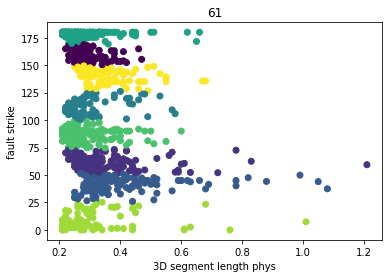

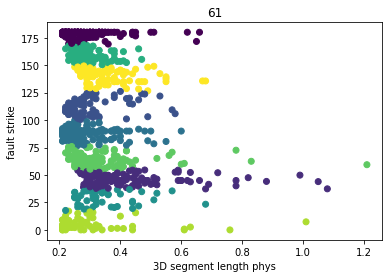

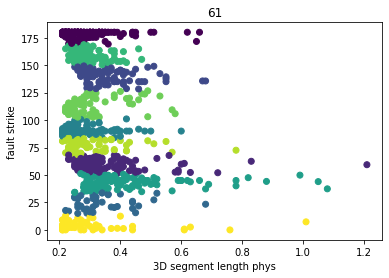

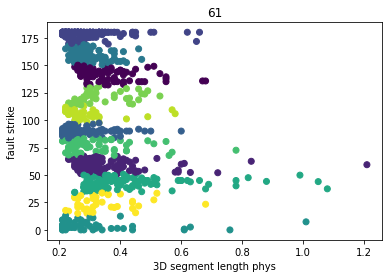

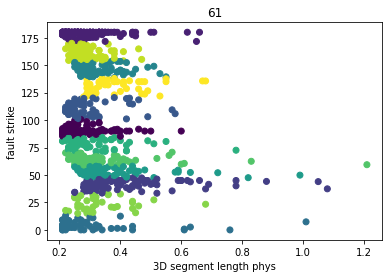

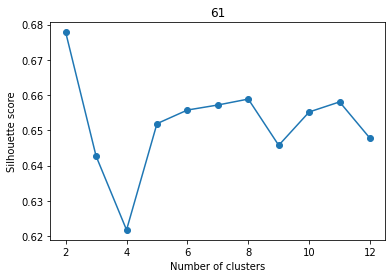

In [76]:
sil=[]
#plt.figure(figsize=(15,10))

i=2 # i=0 for GeolRef, 1 for Matlab results, 2 for 61, 3 for 113
for iclust in range(2,13):
            clusterer = KMeans(n_clusters=iclust, random_state=500)
            cluster_labels = clusterer.fit_predict(df_3Dslp_fs[i])
            score=silhouette_score(df_3Dslp_fs[i],cluster_labels)
            sil.append(score)
            plt.scatter(df_3Dslp_fs[i][:,0],df_3Dslp_fs[i][:,1],c=cluster_labels)
            plt.title("{}{}".format(index[i],degree))
            plt.xlabel('3D segment length phys')
            plt.ylabel('fault strike')
            plt.show()
    
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title("{}{}".format(index[i],degree))
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()


# #Silhouette for clusterer 1: 3D length phys vs 2D segment length phys

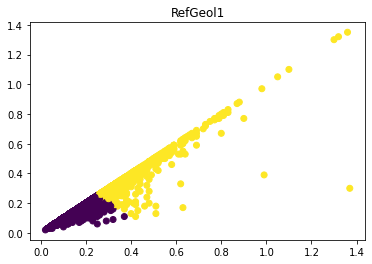

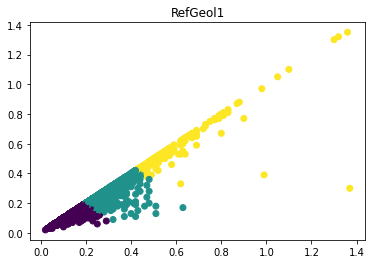

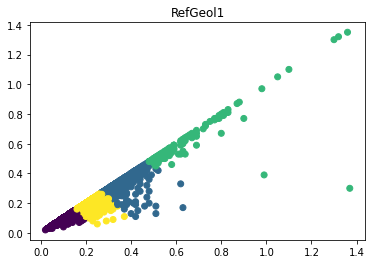

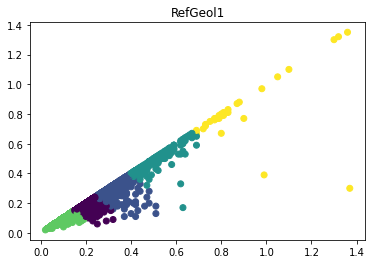

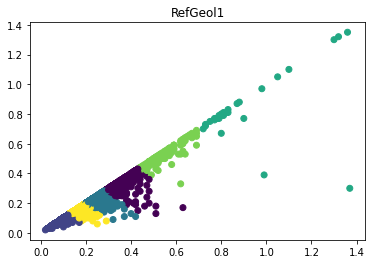

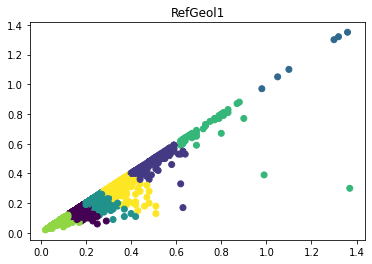

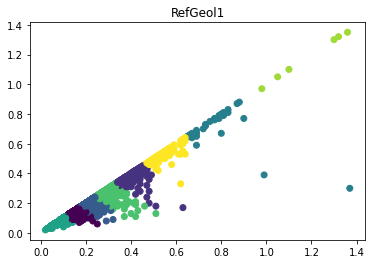

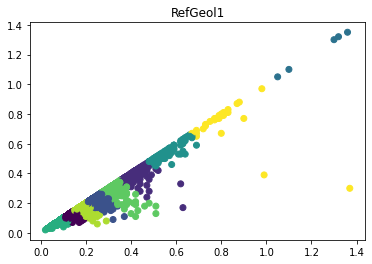

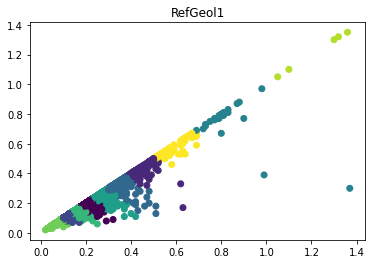

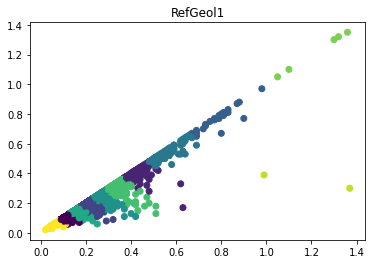

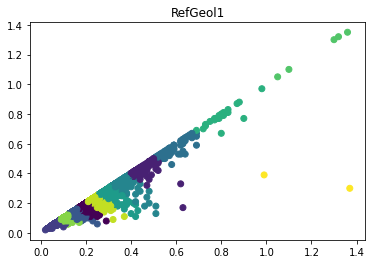

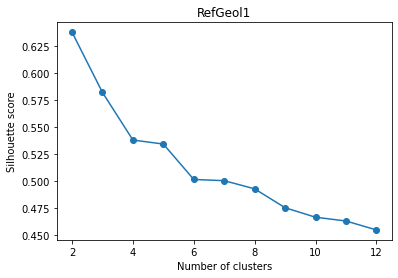

In [77]:
sil=[]
#plt.figure(figsize=(15,10))

i=0 # i=0 for GeolRef, 1 for Matlab results, 2 for 61, 3 for 113
for iclust in range(2,13):
            clusterer = KMeans(n_clusters=iclust, random_state=500)
            cluster_labels = clusterer.fit_predict(df_3Dslp_2Dslp[i])
            score=silhouette_score(df_3Dslp_2Dslp[i],cluster_labels)
            sil.append(score)
            plt.scatter(df_3Dslp_2Dslp[i][:,0],df_3Dslp_2Dslp[i][:,1],c=cluster_labels)
            plt.title("{}{}".format(index[i],degree))
            plt.show()
    
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title("{}{}".format(index[i],degree))
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()



# Covariance

Text(0.5, 1.0, 'Covariance Matrix for RefGeol1')

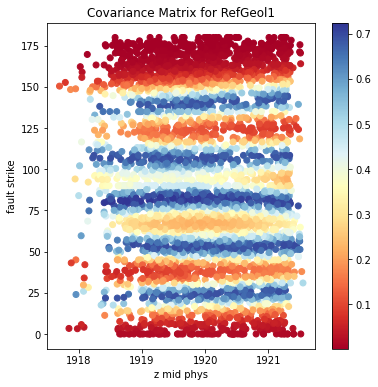

In [78]:
from matplotlib.font_manager import FontProperties
### Inspired from CAS ADS CLass Module 3
#Applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point, 
#but also a probability distribution over the clusters. 

#From this probability distribution, you can compute for each point the entropy of the corresponging 
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction. 
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.

i=0
n_components = 6

from scipy.stats import entropy
points=df_zmp_fs[i] ## INPUT

plt.figure(figsize=(6,6))
clf = GaussianMixture(n_components=n_components, covariance_type='full')

clf.fit(points)

# 3. compute the cluster probabilities using the method predict_proba. This will return a matrix of 
# dimension npoints x nclusters
# 4. use the entropy function ( from scipy.stats import entropy ) to evaluate for each point the uncertainty of the 
#prediction

cluster_labels_prob=clf.predict_proba(points)

entropies=[]
for point in range(len(cluster_labels_prob)):
    entropies.append(entropy(cluster_labels_prob[point]))

# 5. Plot the points colored accordingly to their uncertainty. 

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
plt.colorbar(sc)

plt.xlabel('z mid phys')
plt.ylabel('fault strike')
plt.title("Covariance Matrix for {}{}".format(index[i],degree))
    

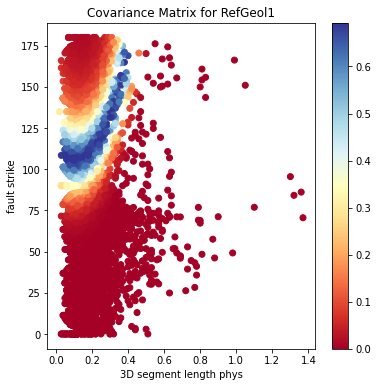

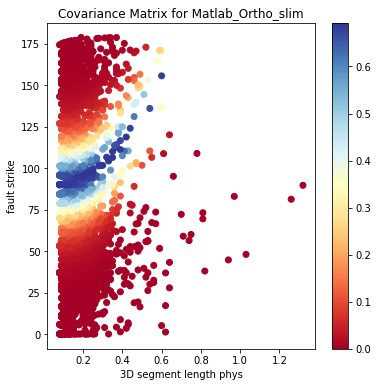

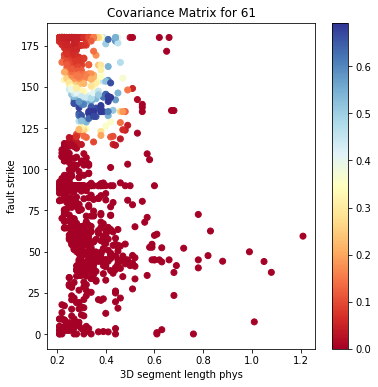

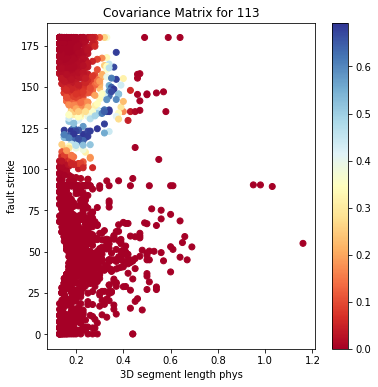

In [79]:
from matplotlib.font_manager import FontProperties
from scipy.stats import entropy
### Inspired from CAS ADS CLass Module 3
#Applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point, 
#but also a probability distribution over the clusters. 

#From this probability distribution, you can compute for each point the entropy of the corresponging 
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction. 
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.


i=0
n_components = 2


for i in range (4):
  points=df_3Dslp_fs[i] ## INPUT
  plt.figure(figsize=(6,6))
  clf = GaussianMixture(n_components=n_components, covariance_type='full')
  clf.fit(points)


  cluster_labels_prob=clf.predict_proba(points)

  entropies=[]
  for point in range(len(cluster_labels_prob)):
      entropies.append(entropy(cluster_labels_prob[point]))

# 5. Plot the points colored accordingly to their uncertainty. 

  cm = plt.cm.get_cmap('RdYlBu')
  sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
  plt.colorbar(sc)

  plt.xlabel('3D segment length phys')
  plt.ylabel('fault strike')
  plt.title("Covariance Matrix for {}{}".format(index[i],degree))
  #plt.savefig('/content/drive/MyDrive/Final_project_ADS/Covariance_Matrix_for_{}{}.png'.format(index[i],degree))

  i=i+1

#plt.savefig('/content/drive/MyDrive/Final_project_ADS/Covariance_zmp_fs_cluster2.png')
    

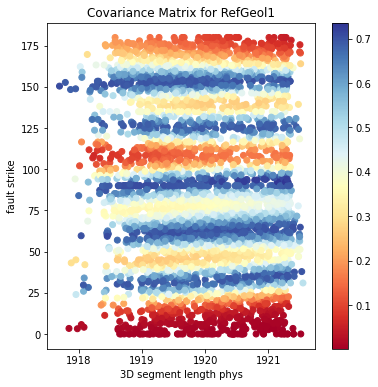

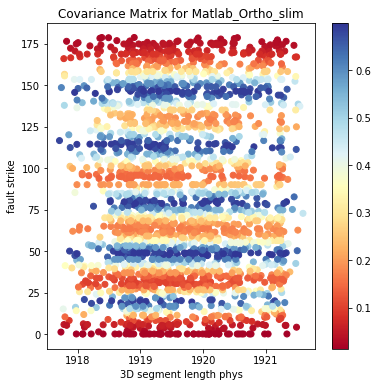

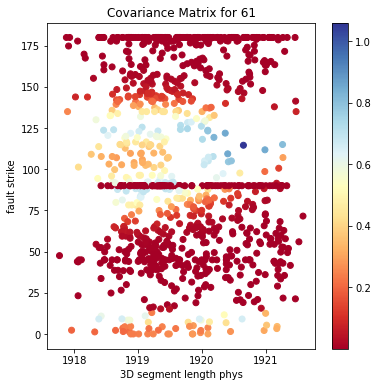

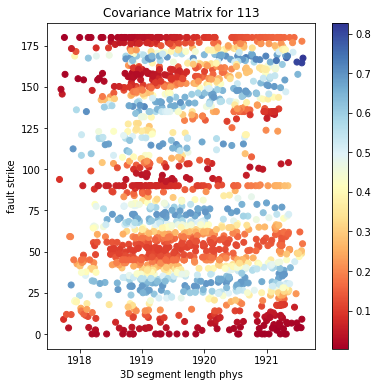

In [80]:
from matplotlib.font_manager import FontProperties
from scipy.stats import entropy
### Inspired from CAS ADS CLass Module 3
#Applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point, 
#but also a probability distribution over the clusters. 

#From this probability distribution, you can compute for each point the entropy of the corresponging 
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction. 
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.


i=0
n_components = 6


for i in range (4):
  points=df_zmp_fs[i] ## INPUT
  plt.figure(figsize=(6,6))
  clf = GaussianMixture(n_components=n_components, covariance_type='full')
  clf.fit(points)


  cluster_labels_prob=clf.predict_proba(points)

  entropies=[]
  for point in range(len(cluster_labels_prob)):
      entropies.append(entropy(cluster_labels_prob[point]))

# 5. Plot the points colored accordingly to their uncertainty. 

  cm = plt.cm.get_cmap('RdYlBu')
  sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
  plt.colorbar(sc)

  plt.xlabel('3D segment length phys')
  plt.ylabel('fault strike')
  plt.title("Covariance Matrix for {}{}".format(index[i],degree))
  #plt.savefig('/content/drive/MyDrive/Final_project_ADS/Covariance_Matrix_for_{}{}.png'.format(index[i],degree))

  i=i+1

#plt.savefig('/content/drive/MyDrive/Final_project_ADS/Covariance_zmp_fs_cluster2.png')